<a href="https://colab.research.google.com/github/CidClayQuirino/DisponibilidadeFisicaEvaluation/blob/main/StatisticCorrelationDF_MTTR_MTBS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# In[0.1]: Instalação dos pacotes

!pip install pandas
!pip install numpy
!pip install -U seaborn
!pip install matplotlib
!pip install plotly
!pip install scipy
!pip install statsmodels
!pip install scikit-learn
!pip install playsound
!pip install pingouin
!pip install emojis
!pip install statstests

# In[0.2]: Importação dos pacotes

import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
import plotly.graph_objects as go # gráficos 3D
from scipy.stats import pearsonr # correlações de Pearson
import statsmodels.api as sm # estimação de modelos
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from sklearn.preprocessing import LabelEncoder # transformação de dados
from playsound import playsound # reprodução de sons
import pingouin as pg # outro modo para obtenção de matrizes de correlações
import emojis # inserção de emojis em gráficos
from statstests.process import stepwise # procedimento Stepwise
from statstests.tests import shapiro_francia # teste de Shapiro-Francia
from scipy.stats import boxcox # transformação de Box-Cox
from scipy.stats import norm # para plotagem da curva normal
from scipy import stats # utilizado na definição da função 'breusch_pagan_test'

In [ ]:
import pandas as pd

# URL do arquivo CSV no GitHub
url = "https://raw.githubusercontent.com/CidClayQuirino/DisponibilidadeFisicaEvaluation/main/KPIsDataBaseHistoric.csv"

# Ler o arquivo CSV especificando o delimitador como ponto e vírgula (;)
df = pd.read_csv(url, encoding='latin1', delimiter=';')

# Selecionar apenas as colunas especificadas
selected_columns = ['timestamp', 'Tipo', 'DF', 'MTBF', 'MTTR', 'MTBS', 'MTTS']
df_selected = df[selected_columns].copy()

# Remover o símbolo de porcentagem e converter DF para valores numéricos entre 0 e 1
df_selected.loc[:, 'DF'] = df_selected['DF'].str.replace('%', '').str.replace(',', '.').astype(float) / 100

# Mapear os meses em português para números sequenciais
month_map = {
    'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6,
    'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12
}

# Função para converter o formato mês/ano em um número sequencial
def convert_to_sequential(date_str):
    month_str, year_str = date_str.split('/')
    month_num = month_map[month_str.lower()]
    year_num = int('20' + year_str)  # Supondo que todos os anos são do século 21 (20xx)
    return (year_num - 2020) * 12 + month_num  # Ajuste a fórmula conforme necessário

# Aplicar a função de conversão na coluna timestamp
df_selected['timestamp_sequencial'] = df_selected['timestamp'].apply(convert_to_sequential)

# Remover a coluna timestamp
df_selected = df_selected.drop(columns=['timestamp','timestamp_sequencial' ])

# Converter as colunas especificadas para float64
cols_to_convert = ['DF', 'MTBF', 'MTTR', 'MTBS', 'MTTS']
df_selected[cols_to_convert] = df_selected[cols_to_convert].replace(',', '.', regex=True).astype(float)

# Gravar o novo DataFrame em um arquivo CSV
df_selected.to_csv("KPIsDataBaseSequencial.csv", index=False)

# Mostrar as primeiras linhas do novo DataFrame
print(df_selected)

df_selected.describe()

                  Tipo     DF   MTBF  MTTR   MTBS  MTTS
0               Patrol  0.509   32.1   3.0   17.3  39.5
1               Patrol  0.848   41.0   3.4   34.2   8.6
2               Patrol  0.929   70.5   6.6   50.4   8.0
3               Patrol  0.263   15.5  10.9    9.9  59.3
4               Patrol  0.852   62.9   5.4   42.0  13.9
...                ...    ...    ...   ...    ...   ...
1439  Trator (Esteira)  0.481   12.8  21.8   12.8  21.8
1440  Trator (Esteira)  0.903   23.1   4.1   23.1   4.1
1441  Trator (Esteira)  0.622   43.2   1.0   28.8  31.8
1442  Trator (Esteira)  0.992  128.5   1.3  128.5   1.3
1443  Trator (Esteira)  1.000    0.0   0.0    0.0   0.0

[1444 rows x 6 columns]


<ipython-input-2-904d73662aaa>:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_selected[cols_to_convert] = df_selected[cols_to_convert].replace(',', '.', regex=True).astype(float)


,DF,MTBF,MTTR,MTBS,MTTS
count,1444.000000,1444.000000,1444.000000,1444.000000,1444.000000
mean,0.667333,55.360111,33.836427,39.574931,46.818352
std,0.262345,70.724063,118.132848,35.815241,124.028606
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.570000,22.000000,3.800000,19.000000,8.700000
50%,0.746000,37.000000,6.800000,31.700000,14.500000
75%,0.850250,65.500000,13.925000,49.625000,29.500000
max,1.000000,677.000000,744.000000,330.100000,744.000000


In [ ]:
import plotly.express as px

# Assuming df_selected is your DataFrame with columns 'DF', 'MTBF', 'MTTR', 'MTBS', and 'MTTS'

# Creating the interactive scatter plot
fig = px.scatter_matrix(df_selected,
                        dimensions=['MTBF', 'MTTR', 'MTBS', 'MTTS'],
                        color='DF',
                        title='Scatter Matrix for DF vs MTBF, MTTR, MTBS, and MTTS',
                        labels={'DF': 'DF', 'MTBF': 'MTBF', 'MTTR': 'MTTR', 'MTBS': 'MTBS', 'MTTS': 'MTTS'},
                        height=800, width=800)

# Display the plot
fig.show()


In [ ]:
correlation_matrix = df_selected.iloc[:,1:6].corr()
correlation_matrix

,DF,MTBF,MTTR,MTBS,MTTS
DF,1.000000,0.398519,-0.509655,0.525221,-0.556746
MTBF,0.398519,1.000000,-0.137159,0.824591,-0.103681
MTTR,-0.509655,-0.137159,1.000000,-0.197300,0.950721
MTBS,0.525221,0.824591,-0.197300,1.000000,-0.184800
MTTS,-0.556746,-0.103681,0.950721,-0.184800,1.000000


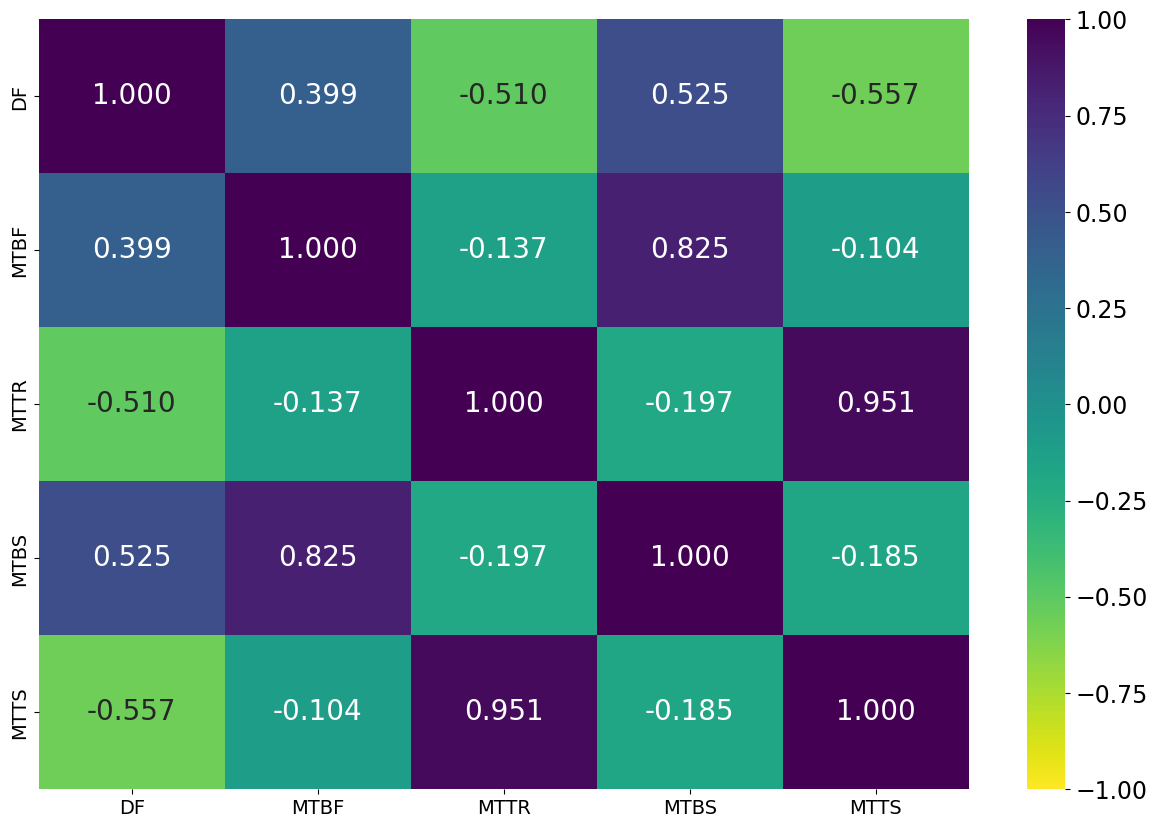

In [ ]:
# Mapa de calor com as correlações entre todas as variáveis quantitativas
plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".3f",
                      cmap=plt.cm.viridis_r,
                      annot_kws={'size': 20}, vmin=-1, vmax=1)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=14)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=14)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=17)
plt.show()


# In[1.2]: CORRELAÇÃO BAIXA (variáveis 'DF' e 'MTBF'):


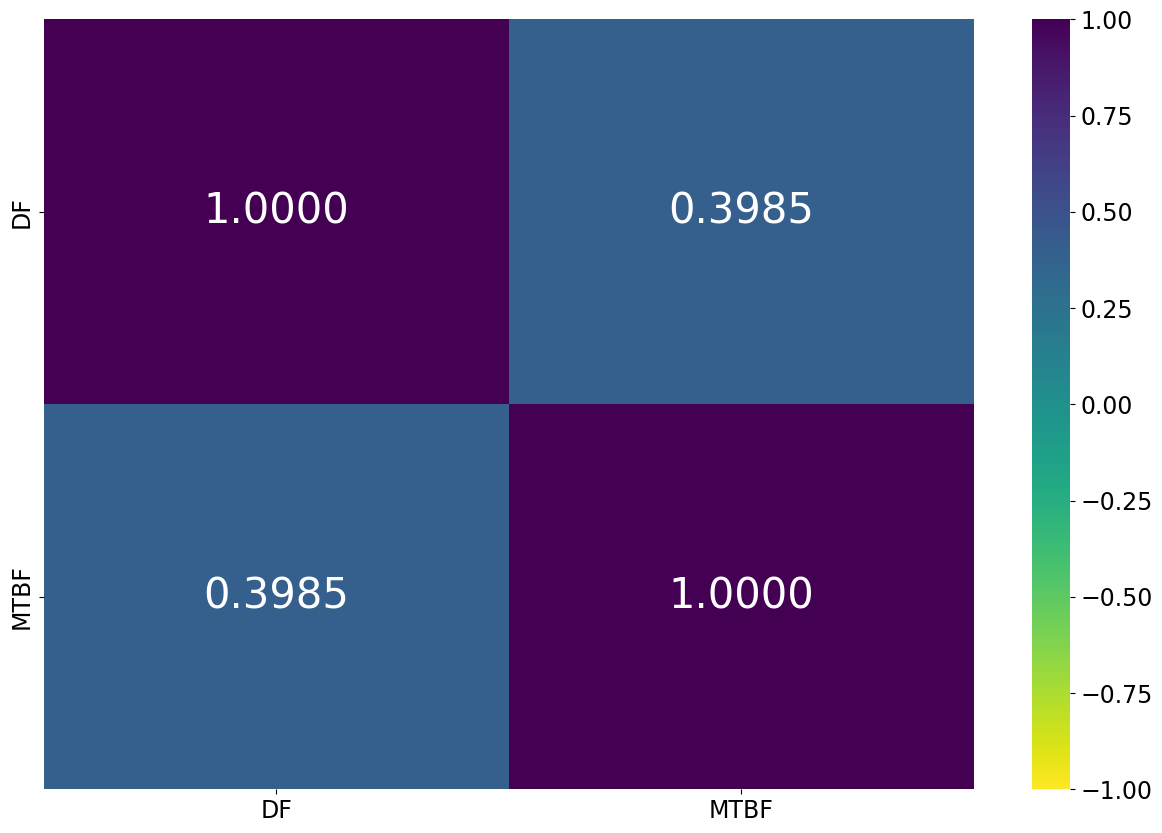

In [ ]:
# Correlação entre 'DF' e 'MTBF', com p-value
corr1, p_value1 = pearsonr(df_selected['DF'], df_selected['MTBF'])
"{:.4f}".format(corr1), "{:.4f}".format(p_value1)

# Matriz de correlação (maneira simples) pela função 'corr'
corr1 = df_selected[['DF','MTBF']].corr()
corr1

# Maneira mais elaborada pela função 'rcorr' do pacote 'pingouin'
import pingouin as pg
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

corr1b = pg.rcorr(df_selected[['DF','MTBF']], method='pearson',
                  upper='pval', decimals=6,
                  pval_stars={0.01: '***',
                              0.05: '**',
                              0.10: '*'})
corr1b

# Mapa de calor com a correlação entre 'rh1' e 'econometria1'
plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(corr1, annot=True, fmt=".4f",
                      cmap=plt.cm.viridis_r,
                      annot_kws={'size': 30}, vmin=-1, vmax=1)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=17)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=17)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=17)
plt.show()

# In[1.2]: CORRELAÇÃO média (variáveis 'DF' e 'MTBS'):


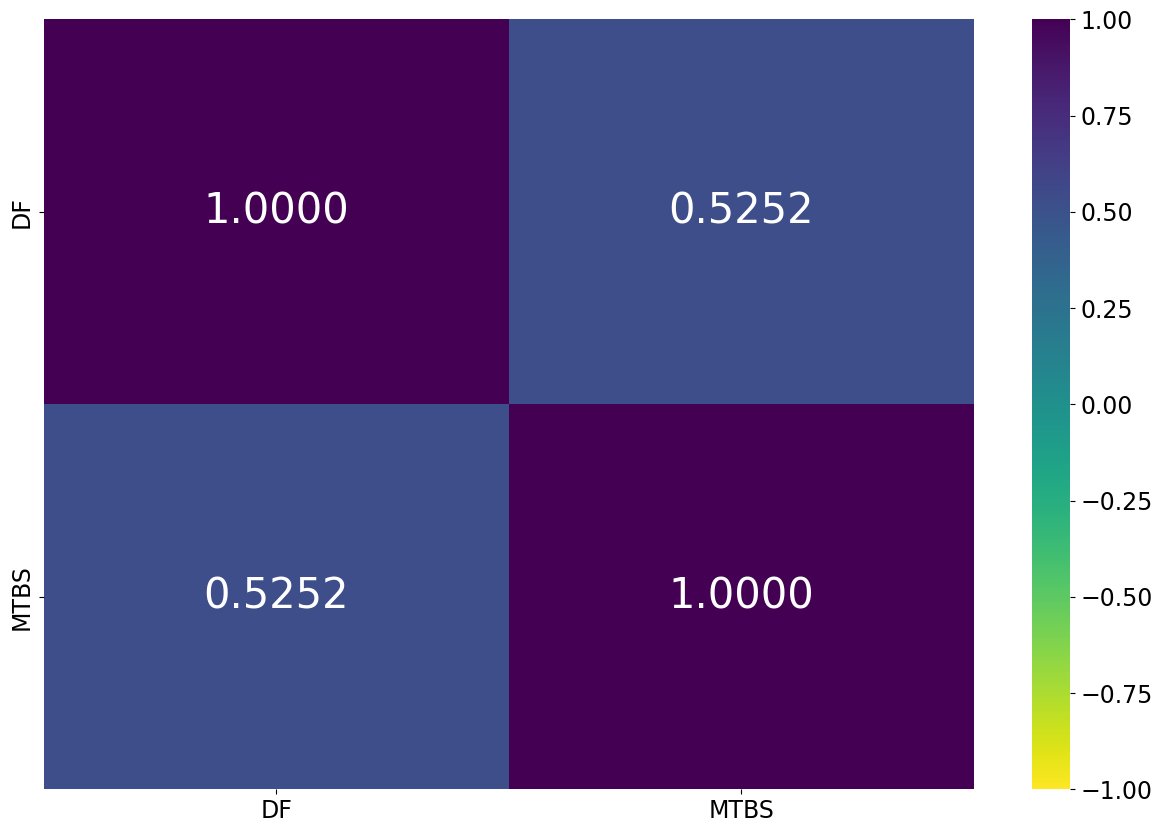

In [ ]:
# Correlação entre 'DF' e 'MTBF', com p-value
corr1, p_value1 = pearsonr(df_selected['DF'], df_selected['MTBS'])
"{:.4f}".format(corr1), "{:.4f}".format(p_value1)

# Matriz de correlação (maneira simples) pela função 'corr'
corr1 = df_selected[['DF','MTBS']].corr()
corr1

# Maneira mais elaborada pela função 'rcorr' do pacote 'pingouin'
import pingouin as pg
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

corr1b = pg.rcorr(df_selected[['DF','MTBS']], method='pearson',
                  upper='pval', decimals=6,
                  pval_stars={0.01: '***',
                              0.05: '**',
                              0.10: '*'})
corr1b

# Mapa de calor com a correlação entre 'rh1' e 'econometria1'
plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(corr1, annot=True, fmt=".4f",
                      cmap=plt.cm.viridis_r,
                      annot_kws={'size': 30}, vmin=-1, vmax=1)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=17)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=17)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=17)
plt.show()

# In[1.2]: CORRELAÇÃO MÉDIA (variáveis 'DF' e 'MTTR'):


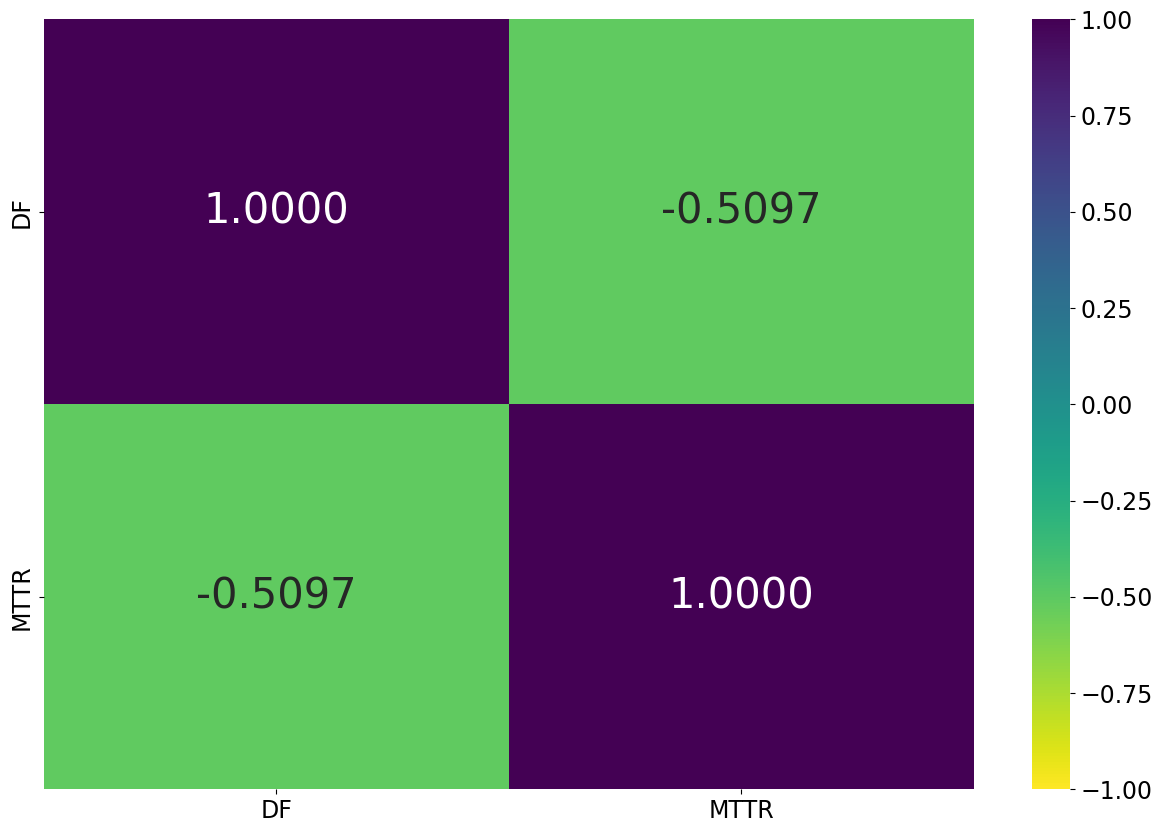

In [ ]:
# Correlação entre 'DF' e 'MTBF', com p-value
corr1, p_value1 = pearsonr(df_selected['DF'], df_selected['MTTR'])
"{:.4f}".format(corr1), "{:.4f}".format(p_value1)

# Matriz de correlação (maneira simples) pela função 'corr'
corr1 = df_selected[['DF','MTTR']].corr()
corr1

# Maneira mais elaborada pela função 'rcorr' do pacote 'pingouin'
import pingouin as pg
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

corr1b = pg.rcorr(df_selected[['DF','MTTR']], method='pearson',
                  upper='pval', decimals=6,
                  pval_stars={0.01: '***',
                              0.05: '**',
                              0.10: '*'})
corr1b

# Mapa de calor com a correlação entre 'rh1' e 'econometria1'
plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(corr1, annot=True, fmt=".4f",
                      cmap=plt.cm.viridis_r,
                      annot_kws={'size': 30}, vmin=-1, vmax=1)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=17)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=17)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=17)
plt.show()

# In[1.2]: CORRELAÇÃO MÉDIA (variáveis 'DF' e 'MTTS'):


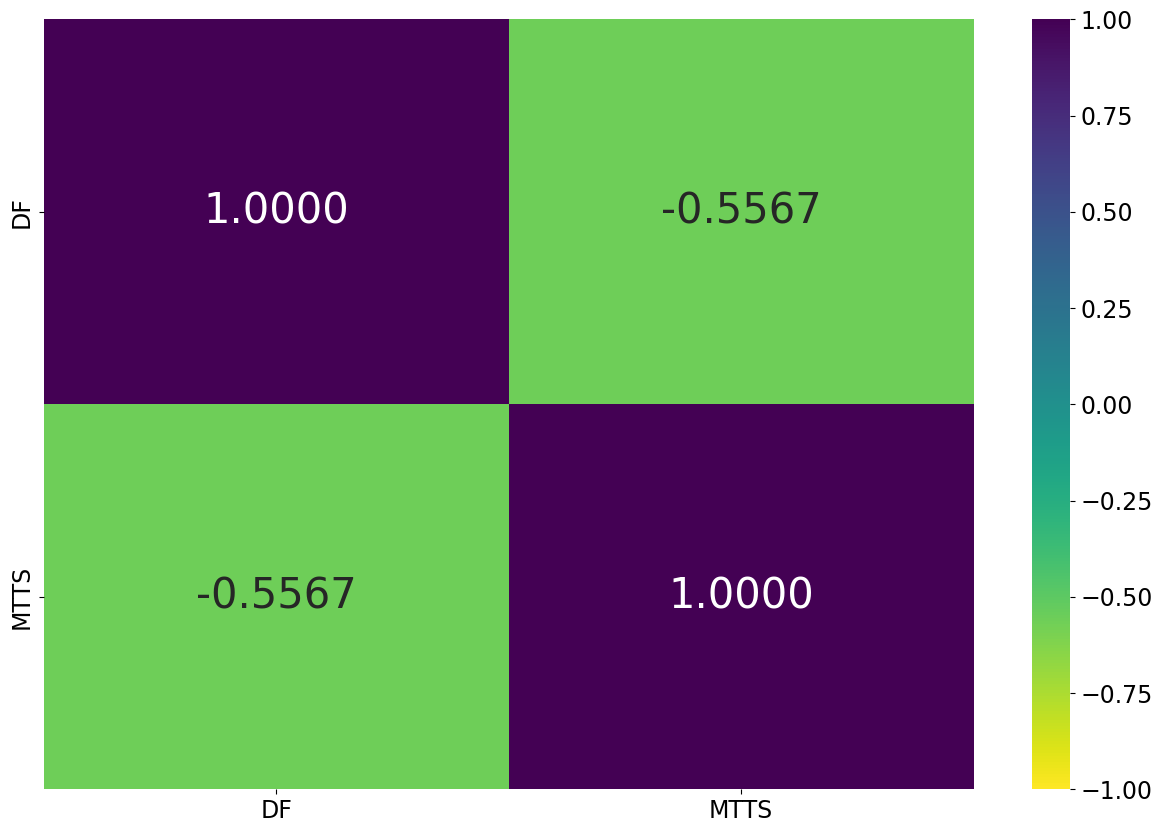

In [ ]:
# Correlação entre 'DF' e 'MTBF', com p-value
corr1, p_value1 = pearsonr(df_selected['DF'], df_selected['MTTS'])
"{:.4f}".format(corr1), "{:.4f}".format(p_value1)

# Matriz de correlação (maneira simples) pela função 'corr'
corr1 = df_selected[['DF','MTTS']].corr()
corr1

# Maneira mais elaborada pela função 'rcorr' do pacote 'pingouin'
import pingouin as pg
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

corr1b = pg.rcorr(df_selected[['DF','MTTS']], method='pearson',
                  upper='pval', decimals=6,
                  pval_stars={0.01: '***',
                              0.05: '**',
                              0.10: '*'})
corr1b

# Mapa de calor com a correlação entre 'rh1' e 'econometria1'
plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(corr1, annot=True, fmt=".4f",
                      cmap=plt.cm.viridis_r,
                      annot_kws={'size': 30}, vmin=-1, vmax=1)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=17)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=17)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=17)
plt.show()

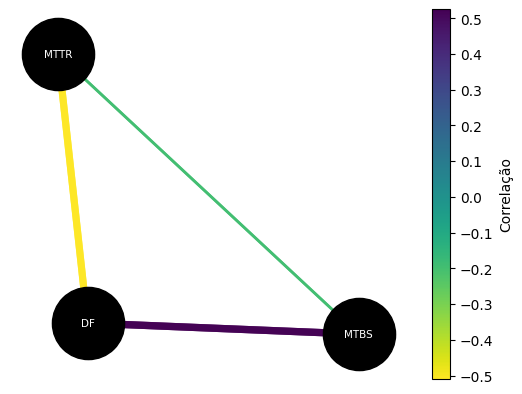

In [ ]:
# In[6.3]: Grafo com a inter-relação entre as variáveis do dataframe 'df1'

df1 = df_selected[['DF','MTBS','MTTR']]
cormat1 = df1.corr()
cormat1

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Criação de um grafo direcionado
G = nx.DiGraph()

# Adição das variáveis como nós do grafo
for variable in cormat1.columns:
    G.add_node(variable)

# Adição das arestas com espessuras proporcionais às correlações
for i, variable1 in enumerate(cormat1.columns):
    for j, variable2 in enumerate(cormat1.columns):
        if i != j:
            correlation = cormat1.iloc[i, j]
            if abs(correlation) > 0:
                G.add_edge(variable1, variable2, weight=correlation)

# Obtenção da lista de correlações das arestas
correlations = [d["weight"] for _, _, d in G.edges(data=True)]

# Definição da dimensão dos nós
node_size = 2700

# Definição da cor dos nós
node_color = 'black'

# Definição da escala de cores das retas (correspondência com as correlações)
cmap = plt.colormaps.get_cmap('viridis_r')

# Criação de uma lista de espessuras das arestas proporcional às correlações
edge_widths = [abs(d["weight"]) * 10 for _, _, d in G.edges(data=True)]

# Criação do layout do grafo com maior distância entre os nós
pos = nx.spring_layout(G, k=0.75)  # k para controlar a distância entre os nós

# Desenho dos nós e das arestas com base nas correlações e espessuras
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=correlations,
                       edge_cmap=cmap, alpha=0.9)

# Adição dos rótulos dos nós
labels = {node: node for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=7.5, font_color='white')

# Ajuste dos limites dos eixos
ax = plt.gca()
ax.margins(0.1)
plt.axis("off")

# Criação da legenda com a escala de cores definida
smp = cm.ScalarMappable(cmap=cmap)
smp.set_array([min(correlations), max(correlations)])
cbar = plt.colorbar(smp, ax=ax, label='Correlação')

# Definição dos ticks da colorbar
cbar.set_ticks(np.arange(round(min(correlations),1),
                         max(correlations), 0.1))

# Exibição do gráfico
plt.show()

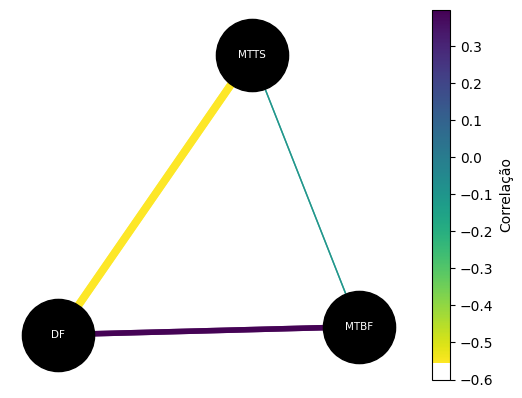

In [ ]:
# In[6.3]: Grafo com a inter-relação entre as variáveis do dataframe 'df1'

df1 = df_selected[['DF','MTBF','MTTS']]
cormat1 = df1.corr()
cormat1

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Criação de um grafo direcionado
G = nx.DiGraph()

# Adição das variáveis como nós do grafo
for variable in cormat1.columns:
    G.add_node(variable)

# Adição das arestas com espessuras proporcionais às correlações
for i, variable1 in enumerate(cormat1.columns):
    for j, variable2 in enumerate(cormat1.columns):
        if i != j:
            correlation = cormat1.iloc[i, j]
            if abs(correlation) > 0:
                G.add_edge(variable1, variable2, weight=correlation)

# Obtenção da lista de correlações das arestas
correlations = [d["weight"] for _, _, d in G.edges(data=True)]

# Definição da dimensão dos nós
node_size = 2700

# Definição da cor dos nós
node_color = 'black'

# Definição da escala de cores das retas (correspondência com as correlações)
cmap = plt.colormaps.get_cmap('viridis_r')

# Criação de uma lista de espessuras das arestas proporcional às correlações
edge_widths = [abs(d["weight"]) * 10 for _, _, d in G.edges(data=True)]

# Criação do layout do grafo com maior distância entre os nós
pos = nx.spring_layout(G, k=0.75)  # k para controlar a distância entre os nós

# Desenho dos nós e das arestas com base nas correlações e espessuras
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=correlations,
                       edge_cmap=cmap, alpha=0.9)

# Adição dos rótulos dos nós
labels = {node: node for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=7.5, font_color='white')

# Ajuste dos limites dos eixos
ax = plt.gca()
ax.margins(0.1)
plt.axis("off")

# Criação da legenda com a escala de cores definida
smp = cm.ScalarMappable(cmap=cmap)
smp.set_array([min(correlations), max(correlations)])
cbar = plt.colorbar(smp, ax=ax, label='Correlação')

# Definição dos ticks da colorbar
cbar.set_ticks(np.arange(round(min(correlations),1),
                         max(correlations), 0.1))

# Exibição do gráfico
plt.show()

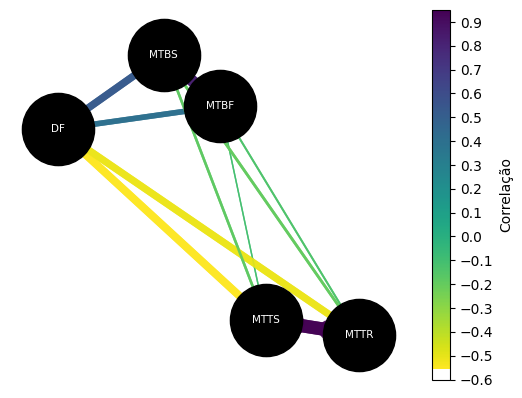

In [ ]:
# In[6.3]: Grafo com a inter-relação entre as variáveis do dataframe 'df1'

df1 = df_selected[['DF','MTBF','MTTS', 'MTTR', 'MTBS']]
cormat1 = df1.corr()
cormat1

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Criação de um grafo direcionado
G = nx.DiGraph()

# Adição das variáveis como nós do grafo
for variable in cormat1.columns:
    G.add_node(variable)

# Adição das arestas com espessuras proporcionais às correlações
for i, variable1 in enumerate(cormat1.columns):
    for j, variable2 in enumerate(cormat1.columns):
        if i != j:
            correlation = cormat1.iloc[i, j]
            if abs(correlation) > 0:
                G.add_edge(variable1, variable2, weight=correlation)

# Obtenção da lista de correlações das arestas
correlations = [d["weight"] for _, _, d in G.edges(data=True)]

# Definição da dimensão dos nós
node_size = 2700

# Definição da cor dos nós
node_color = 'black'

# Definição da escala de cores das retas (correspondência com as correlações)
cmap = plt.colormaps.get_cmap('viridis_r')

# Criação de uma lista de espessuras das arestas proporcional às correlações
edge_widths = [abs(d["weight"]) * 10 for _, _, d in G.edges(data=True)]

# Criação do layout do grafo com maior distância entre os nós
pos = nx.spring_layout(G, k=0.75)  # k para controlar a distância entre os nós

# Desenho dos nós e das arestas com base nas correlações e espessuras
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=correlations,
                       edge_cmap=cmap, alpha=0.9)

# Adição dos rótulos dos nós
labels = {node: node for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=7.5, font_color='white')

# Ajuste dos limites dos eixos
ax = plt.gca()
ax.margins(0.1)
plt.axis("off")

# Criação da legenda com a escala de cores definida
smp = cm.ScalarMappable(cmap=cmap)
smp.set_array([min(correlations), max(correlations)])
cbar = plt.colorbar(smp, ax=ax, label='Correlação')

# Definição dos ticks da colorbar
cbar.set_ticks(np.arange(round(min(correlations),1),
                         max(correlations), 0.1))

# Exibição do gráfico
plt.show()

In [ ]:
# In[6.4]: Modelo 1

modelo1 = sm.OLS.from_formula('DF ~ MTBS', df_selected).fit()

modelo1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     DF   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     549.3
Date:                Fri, 23 Aug 2024   Prob (F-statistic):          3.42e-103
Time:                        16:27:14   Log-Likelihood:                 116.80
No. Observations:                1444   AIC:                            -229.6
Df Residuals:                    1442   BIC:                            -219.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5151      0.009     58.799      0.000       0.498       0.532
MTBS           0.0038      0.000     23.438      0.000       0.004       0.004
==============================================================================
Omnibus:                      213.647   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              313.999
Skew:                          -1.120   Prob(JB):                     6.54e-69
Kurtosis:                       3.452   Cond. No.                         79.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
from statstests.process import stepwise

modelo1_step = stepwise(modelo1, pvalue_limit=0.05)



Regression type: OLS 

Estimating model...: 
 DF ~ Q('MTBS')

 No more atributes with p-value higher than 0.05

 Atributes discarded on the process...: 


 Model after stepwise process...: 
 DF ~ Q('MTBS') 

                            OLS Regression Results                            
Dep. Variable:                     DF   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     549.3
Date:                Fri, 23 Aug 2024   Prob (F-statistic):          3.42e-103
Time:                        16:28:42   Log-Likelihood:                 116.80
No. Observations:                1444   AIC:                            -229.6
Df Residuals:                    1442   BIC:                            -219.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
  

In [ ]:
# In[6.4]: Modelo 1

modelo2 = sm.OLS.from_formula('DF ~ MTTR', df_selected).fit()

modelo2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     DF   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     506.0
Date:                Fri, 23 Aug 2024   Prob (F-statistic):           2.74e-96
Time:                        18:02:49   Log-Likelihood:                 100.92
No. Observations:                1444   AIC:                            -197.8
Df Residuals:                    1442   BIC:                            -187.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7056      0.006    114.160      0.000       0.694       0.718
MTTR          -0.0011   5.03e-05    -22.494      0.000      -0.001      -0.001
==============================================================================
Omnibus:                      353.157   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              705.984
Skew:                          -1.435   Prob(JB):                    4.98e-154
Kurtosis:                       4.871   Cond. No.                         128.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
from statstests.process import stepwise

modelo2_step = stepwise(modelo2, pvalue_limit=0.05)


Regression type: OLS 

Estimating model...: 
 DF ~ Q('MTTR')

 No more atributes with p-value higher than 0.05

 Atributes discarded on the process...: 


 Model after stepwise process...: 
 DF ~ Q('MTTR') 

                            OLS Regression Results                            
Dep. Variable:                     DF   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     506.0
Date:                Fri, 23 Aug 2024   Prob (F-statistic):           2.74e-96
Time:                        18:03:40   Log-Likelihood:                 100.92
No. Observations:                1444   AIC:                            -197.8
Df Residuals:                    1442   BIC:                            -187.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
  

In [ ]:
# In[6.5]: Diagnóstico de multicolinearidade (Variance Inflation Factor
#e Tolerance)

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculando os valores de VIF
X1 = sm.add_constant(df_selected[['DF', 'MTBS']])
VIF = pd.DataFrame()
VIF["Variável"] = X1.columns[1:]
VIF["VIF"] = [variance_inflation_factor(X1.values, i+1)
              for i in range(X1.shape[1]-1)]

# Calculando as Tolerâncias
VIF["Tolerância"] = 1 / VIF["VIF"]
VIF


,Variável,VIF,Tolerância
0,DF,1.380943,0.724143
1,MTBS,1.380943,0.724143


In [ ]:
# In[6.5]: Diagnóstico de multicolinearidade (Variance Inflation Factor
#e Tolerance)

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculando os valores de VIF
X2 = sm.add_constant(df_selected[['DF', 'MTTR']])
VIF = pd.DataFrame()
VIF["Variável"] = X2.columns[1:]
VIF["VIF"] = [variance_inflation_factor(X2.values, i+1)
              for i in range(X2.shape[1]-1)]

# Calculando as Tolerâncias
VIF["Tolerância"] = 1 / VIF["VIF"]
VIF

,Variável,VIF,Tolerância
0,DF,1.350891,0.740252
1,MTTR,1.350891,0.740252


            DF      MTBS
DF    1.000000  0.525221
MTBS  0.525221  1.000000


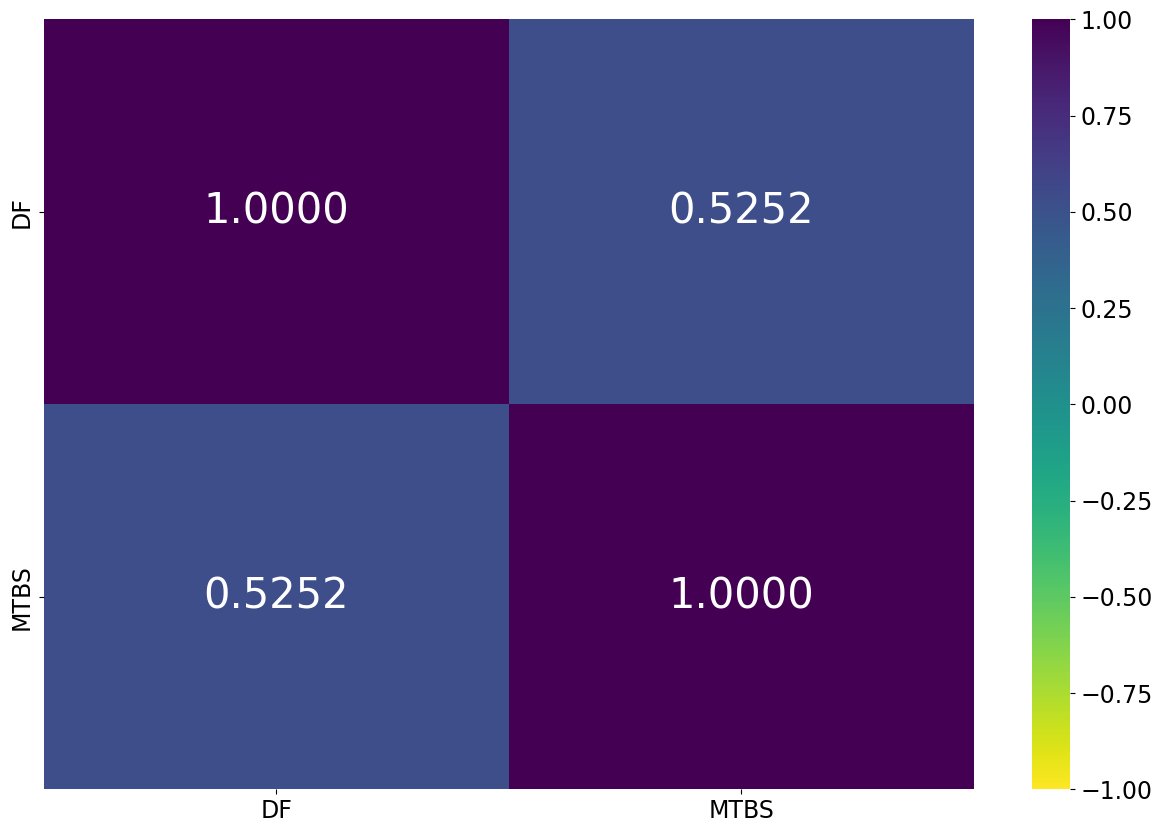

In [ ]:
# In[6.6]: CORRELAÇÃO MUITO ALTA (variáveis 'rh2' e 'econometria2'):

# Correlação entre 'rh2' e 'econometria2', com p-value
corr2, p_value2 = pearsonr(df_selected['DF'], df_selected['MTBS'])
"{:.4f}".format(corr2), "{:.4f}".format(p_value2)

# Matriz de correlação (maneira simples) pela função 'corr'
corr2 = df_selected[['DF','MTBS']].corr()
print(corr2)

# Maneira mais elaborada pela função 'rcorr' do pacote 'pingouin'
import pingouin as pg

corr2b = pg.rcorr(df_selected[['DF','MTBS']], method='pearson',
                  upper='pval', decimals=6,
                  pval_stars={0.01: '***',
                              0.05: '**',
                              0.10: '*'})
corr2b

# Mapa de calor com a correlação entre 'rh2' e 'econometria2'
plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(corr2, annot=True, fmt=".4f",
                      cmap=plt.cm.viridis_r,
                      annot_kws={'size': 30}, vmin=-1, vmax=1)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=17)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=17)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=17)
plt.show()


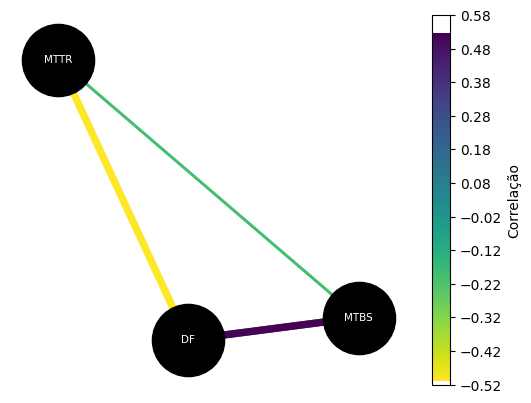

In [ ]:
# In[6.7]: Grafo com a inter-relação entre as variáveis do dataframe 'df2'

df2 = df_selected[['DF','MTBS','MTTR']]
cormat2 = df2.corr()
cormat2

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Criação de um grafo direcionado
G = nx.DiGraph()

# Adição das variáveis como nós do grafo
for variable in cormat2.columns:
    G.add_node(variable)

# Adição das arestas com espessuras proporcionais às correlações
for i, variable1 in enumerate(cormat2.columns):
    for j, variable2 in enumerate(cormat2.columns):
        if i != j:
            correlation = cormat2.iloc[i, j]
            if abs(correlation) > 0:
                G.add_edge(variable1, variable2, weight=correlation)

# Obtenção da lista de correlações das arestas
correlations = [d["weight"] for _, _, d in G.edges(data=True)]

# Definição da dimensão dos nós
node_size = 2700

# Definição da cor dos nós
node_color = 'black'

# Definição da escala de cores das retas (correspondência com as correlações)
cmap = plt.colormaps.get_cmap('viridis_r')

# Criação de uma lista de espessuras das arestas proporcional às correlações
edge_widths = [abs(d["weight"]) * 10 for _, _, d in G.edges(data=True)]

# Criação do layout do grafo com maior distância entre os nós
pos = nx.spring_layout(G, k=0.75)  # k para controlar a distância entre os nós

# Desenho dos nós e das arestas com base nas correlações e espessuras
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=correlations,
                       edge_cmap=cmap, alpha=0.9)

# Adição dos rótulos dos nós
labels = {node: node for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=7.5, font_color='white')

# Ajuste dos limites dos eixos
ax = plt.gca()
ax.margins(0.1)
plt.axis("off")

# Criação da legenda com a escala de cores definida
smp = cm.ScalarMappable(cmap=cmap)
smp.set_array([min(correlations), max(correlations)])
cbar = plt.colorbar(smp, ax=ax, label='Correlação')

# Definição dos ticks da colorbar
cbar.set_ticks(np.arange(round(min(correlations) - 0.01,2),
                         max(correlations) + 0.1, 0.1))

# Exibição do gráfico
plt.show()


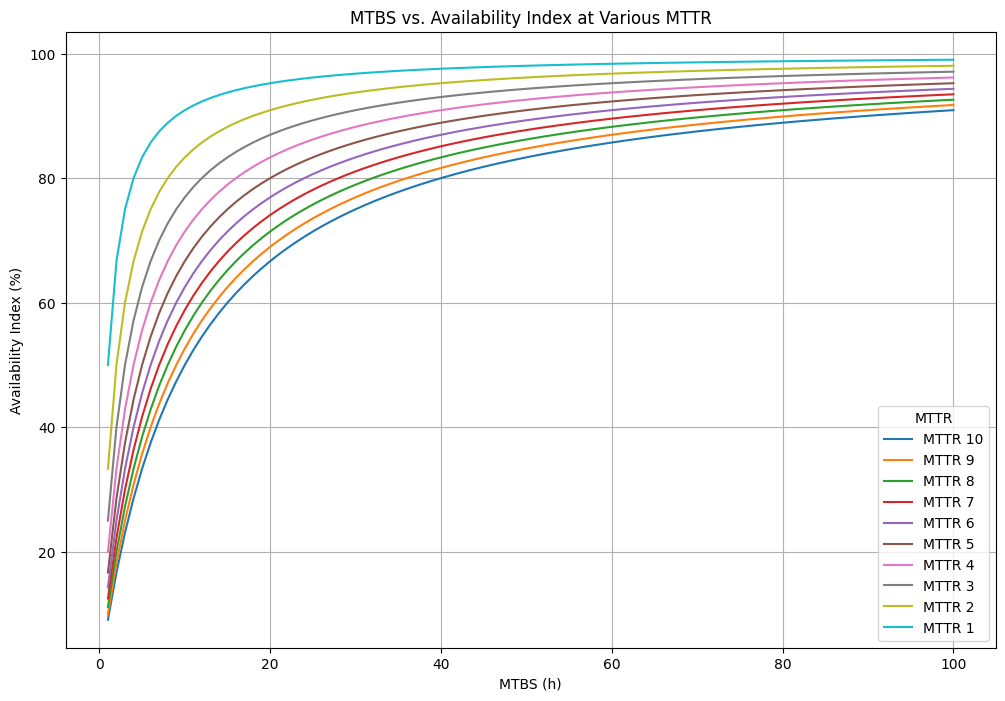

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Configuração dos dados
mtbs_values = np.arange(1, 101, 1)  # MTBS variando de 1 a 100 horas
mttr_values = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]  # Valores fixos de MTTR em ordem decrescente

# Criando o gráfico
plt.figure(figsize=(12, 8))

for mttr in mttr_values:
    ai_values = (mtbs_values / (mtbs_values + mttr)) * 100  # Cálculo do índice de disponibilidade
    plt.plot(mtbs_values, ai_values, label=f"MTTR {mttr}")

# Configurações do gráfico
plt.title("MTBS vs. Availability Index at Various MTTR")
plt.xlabel("MTBS (h)")
plt.ylabel("Availability Index (%)")
plt.legend(title="MTTR", loc="lower right")
plt.grid(True)

# Exibir o gráfico
plt.show()


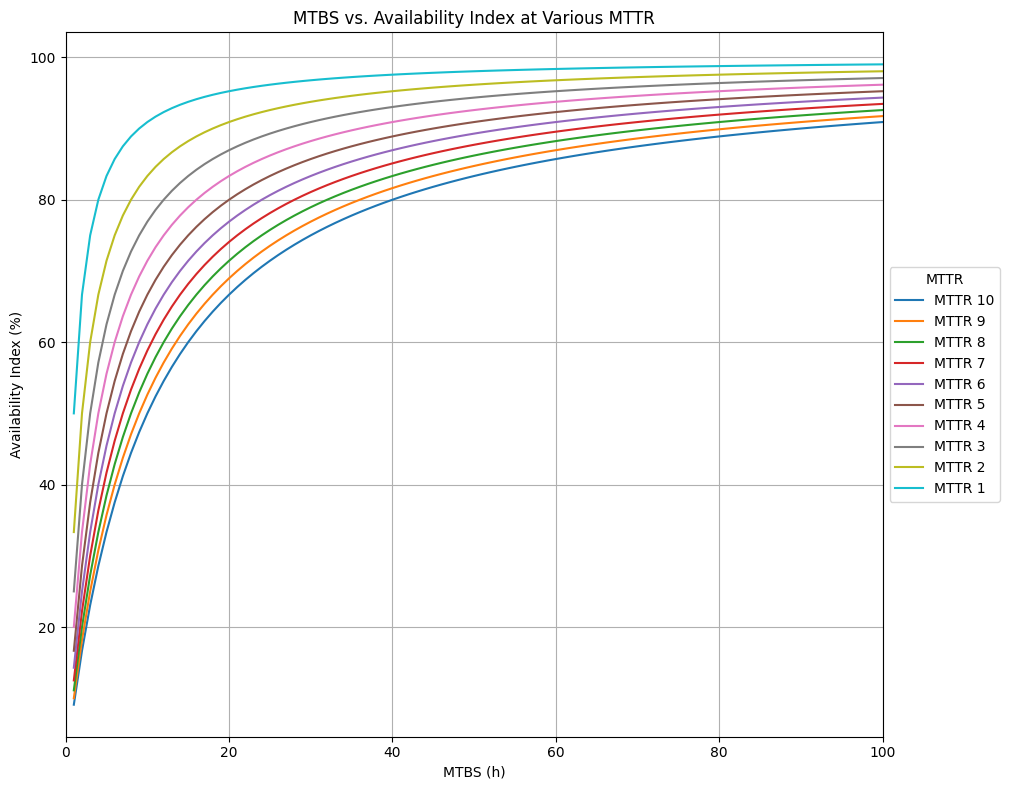

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Configuração dos dados
mtbs_values = np.arange(1, 101, 1)  # MTBS variando de 1 a 100 horas
mttr_values = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]  # Valores fixos de MTTR em ordem decrescente

# Criando o gráfico
plt.figure(figsize=(12, 8))

for mttr in mttr_values:
    ai_values = (mtbs_values / (mtbs_values + mttr)) * 100  # Cálculo do índice de disponibilidade
    plt.plot(mtbs_values, ai_values, label=f"MTTR {mttr}")

# Configurações do gráfico
plt.title("MTBS vs. Availability Index at Various MTTR")
plt.xlabel("MTBS (h)")
plt.ylabel("Availability Index (%)")

# Configuração dos limites do eixo x para iniciar em 0
plt.xlim(0, 100)

# Posicionando a legenda fora da área do gráfico
plt.legend(title="MTTR", loc="center left", bbox_to_anchor=(1, 0.5))  # Coloca a legenda à direita do gráfico
plt.grid(True)

# Ajuste dos limites da área de exibição para acomodar a legenda
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Exibir o gráfico
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Configuração dos dados
mtbs_values = np.arange(1, 101, 1)  # MTBS variando de 1 a 100 horas
mttr_values = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]  # Valores fixos de MTTR em ordem decrescente

# Criando o gráfico
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("MTBS vs. Availability Index at Various MTTR")
ax.set_xlabel("MTBS (h)")
ax.set_ylabel("Availability Index (%)")
ax.set_xlim(1, 100)
ax.set_ylim(0, 100)
plt.grid(True)

# Criar uma linha para cada valor de MTTR (inicialmente vazias)
lines = [ax.plot([], [], label=f"MTTR {mttr}")[0] for mttr in mttr_values]

# Adicionar a legenda fora da área do gráfico
ax.legend(title="MTTR", loc="center left", bbox_to_anchor=(1, 0.5))

# Função de atualização do gráfico baseada no valor do slider
def update(frame):
    for idx, mttr in enumerate(mttr_values):
        ai_values = (mtbs_values[:frame] / (mtbs_values[:frame] + mttr)) * 100  # Calcula valores até o quadro atual
        lines[idx].set_data(mtbs_values[:frame], ai_values)  # Atualiza os dados da linha
    clear_output(wait=True)
    display(slider)
    display(fig)
    fig.canvas.draw_idle()  # Redesenha o gráfico

# Criar o slider
slider = widgets.IntSlider(value=1, min=1, max=len(mtbs_values), step=1, description='Frame')

# Conectar o slider à função de atualização
slider.observe(lambda change: update(slider.value), names='value')

# Exibir o slider e o gráfico
display(slider)
display(fig)
